# Dissipation

GRANAD supports two dissipation models: A phenomenological dissipator, given by

$$\mathcal{D}[\rho - \rho_0] = \frac{-1}{\tau} (\rho - \rho_0)$$

where $\rho_0$ is the equilibrium density matrix and $1 / \tau$ a phenomenological relaxation rate.

To model dissipation in greater depth, GRANAD makes available also a Lindblad dissipation model. The mathematical details are laid out in [Pelc et al., 2024](https://link.aps.org/doi/10.1103/PhysRevA.109.022237) and revolve around the following equation

$$\gamma_{ij}(t) = \gamma_{ij} \cdot f(\rho(t))$$

where $\gamma_{ij}$ is the transition rate from state i to state j and $f$ is a relaxation functional to counteract problems related to the Pauli principle breaking that might occur in the single-particle model.
GRANAD's default relaxation functional suppresses population growth if the population approaches a limiting value of 2. It is given by a sigmoid

$$f(x) = \frac{1}{1 + e^{\beta \cdot(2 - x)}}$$

where x is the occupation and $\beta$ a temperature-like control parameter to mimick a smooth Heaviside function, defaulting to 1e-6.

## Lindblad vs Phenomenological Relaxation dynamics of the Metallic Chain

In the following, we will consider a metallic chain with a uniform transition rate, such that of $\gamma_{ij} = \gamma$ for all $i \gt j$. We consider an initially excited state of one electron in the HOMO-LUMO+1 transition.

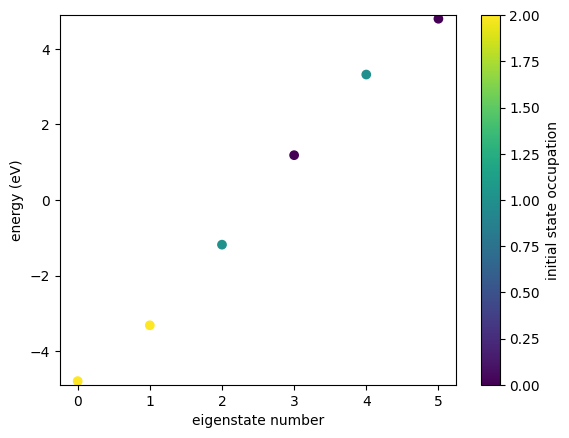

In [1]:
from granad import MaterialCatalog

flake = MaterialCatalog.get("chain").cut_flake( 6 )
flake.set_excitation(flake.homo, flake.homo+2, 1)
flake.show_energies()

We can now build the matrix of transition rates with a uniform $\gamma = 10$ as follows

In [2]:
delta = flake.energies[:,None] - flake.energies
gamma = 10.
gamma_matrix = gamma * (delta > 0)

We can inspect the lumo-homo transition rate, for example, as

In [3]:
print(gamma_matrix[flake.homo+1, flake.homo])

10.0


GRANAD dispatches the non-Hermitian functional depending on the `relaxation_rate` input type. If you pass a float, GRANAD uses the decoherence approximation. If you pass an array, it uses the Lindblad dissipator with a (smooth approximation of) the Heaviside function as the saturation functional. Modifications of the relaxation functional are discussed below.

We now integrate the master equation. 

In [4]:
result = flake.master_equation(relaxation_rate = gamma_matrix,
                               end_time = 0.2,
                               density_matrix = ['occ_e'],
                               )

RHS compiled
RHS compiled


100.0 %


We plot the changes in single-particle energy occupations as a function of time by defining the `plot_labels` argument as the energies

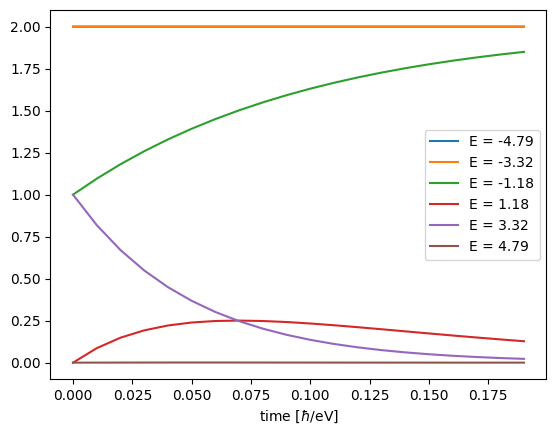

In [5]:
labels = [f"E = {e:.2f}" for e in flake.energies] 
flake.show_res(result, show_illumination=False, plot_labels = labels)

A comparison to to the phenomenological approach can be obtained by

RHS compiled
RHS compiled


100.0 %


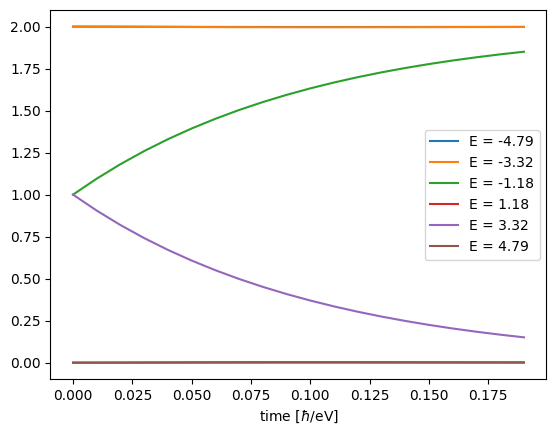

In [6]:
result = flake.master_equation(relaxation_rate = gamma,
                               end_time = 0.2,
                               density_matrix = ['occ_e'],
                               )
flake.show_res(result, show_illumination=False, plot_labels = labels)

By comparing the two plots above, we observe a set of qualitative differences, discussed in greater detail in the [corresponding paper](https://link.aps.org/doi/10.1103/PhysRevA.109.022237).

GRANAD imposes a degeneracy tolerance on the states. This means that all states separated by less than a numerical threshold are considered degenerate. The threshold is specified as variable `flake.params.eps`.

## Modifying the saturation functional

The saturation functional can be customized by defining a saturation function and modifying the dissipator dict (for more information, please consult the tutorial on custom time evolution).

1. initialize a dissipator with your custom relaxation functional
2. pass `relaxation_rate = gamma_matrix` as usual

To illustrate the necessity of introducing a saturation functional, we consider the case where no saturation is applied, i.e. $f(x) = 1$

RHS compiled
RHS compiled


100.0 %


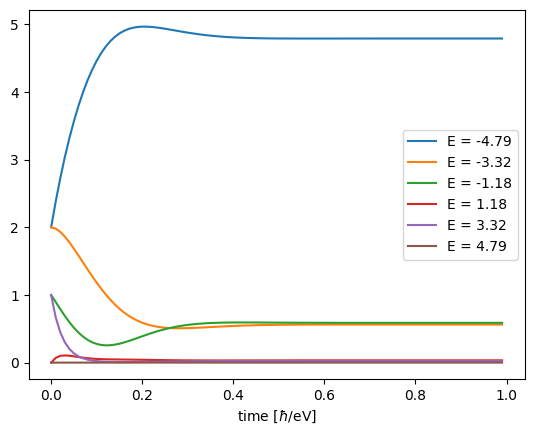

In [7]:
import jax.numpy as jnp
def no_saturation(x):
    return 1.

dissipator = flake.get_dissipator(saturation = no_saturation)

result = flake.master_equation(relaxation_rate = gamma_matrix,
                               dissipator = dissipator,
                               end_time = 1,
                               density_matrix = ['occ_e'],
                               )
flake.show_res(result, show_illumination=False, plot_labels = labels)

We observe an almost complete collapse into the single-particle ground state. The nonzero stationary occupation of excited states can be revealed to be an Coulomb interaction effect.

RHS compiled
RHS compiled


100.0 %


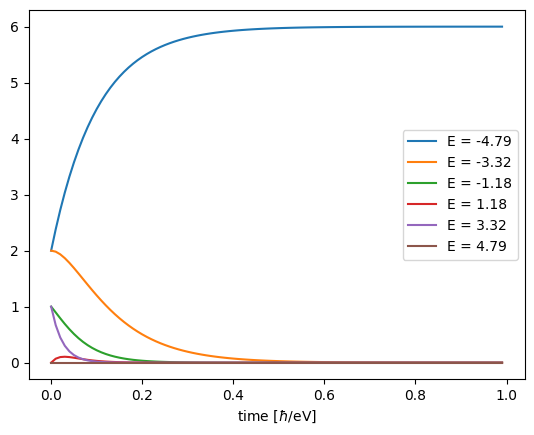

In [8]:
result = flake.master_equation(relaxation_rate = gamma_matrix,
                               dissipator = dissipator,
                               end_time = 1,
                               density_matrix = ['occ_e'],
                               coulomb_strength = 0. # turn off Coulomb interaction
                               )
flake.show_res(result, show_illumination=False, plot_labels = labels)

## Wigner-Weisskopf transition rates

GRANAD offers the single-particle Wigner-Weisskopf transition rates that can be represented directly in a matrix form. The "ij" matrix element corresponds to the relaxation rate from the state i to j.

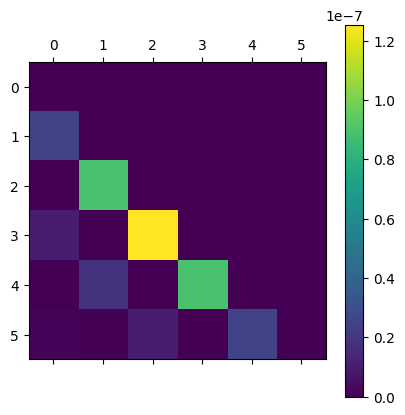

In [9]:
import matplotlib.pyplot as plt
gamma_matrix = flake.wigner_weisskopf_transition_rates
plt.matshow(gamma_matrix)
plt.colorbar()
plt.show()